In [51]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
from models import EvenBinaryClassifier
import torch
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


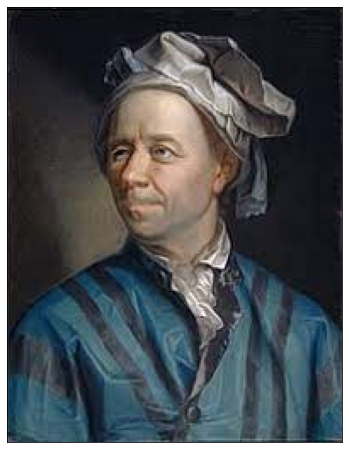

In [52]:
rgb = image.imread("euler.jpg")
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(rgb)
lines, columns = rgb.shape[:-1]

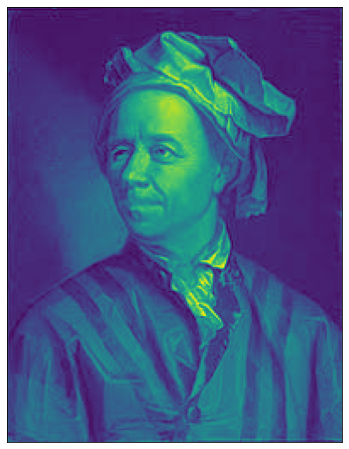

In [53]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(grey)
filename_png = 'euler_gray_scale.png'
figure.savefig(filename_png, bbox_inches='tight', pad_inches=0)

In [56]:
#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lines, columns = grey.shape
num_samples = 100000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([((categorical_samples//columns + torch.rand(num_samples))/lines).unsqueeze(-1), ((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1)], dim = -1)

C:\Users\EA264728\AppData\Local\Temp/ipykernel_22792/4025941441.py:8: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([((categorical_samples//columns + torch.rand(num_samples))/lines).unsqueeze(-1), ((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1)], dim = -1)


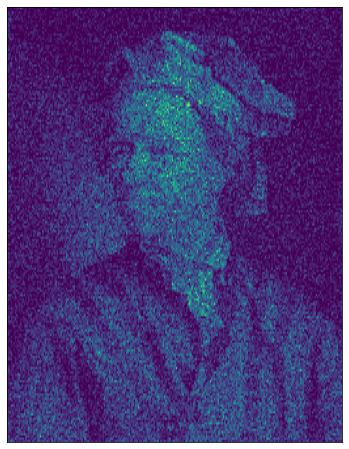

In [57]:
hist_target_samples, x_edges, y_edges = np.histogram2d(target_samples[:,1].numpy(), target_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_target_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

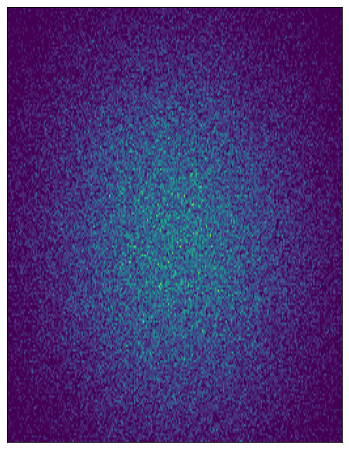

In [63]:
cov = torch.cov(target_samples.T)
q_samples = torch.distributions.MultivariateNormal(torch.mean(target_samples, dim = 0), 1/2*cov + 1/2*cov.T).sample([100000])
hist_q_samples, x_edges, y_edges = np.histogram2d(q_samples[:,1].numpy(), q_samples[:, 0].numpy(), bins = (lines, columns),range =[[0,1],[0,1]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_q_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [80]:
classif = EvenBinaryClassifier(target_samples, q_samples, [64,64,64])
classif.train(100,10000, lr = 1e-2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:03<00:00,  3.63s/it, loss = 1.236945]


In [77]:
from torch.distributions import Categorical
def resample_dependant(x):
    ratio = torch.exp(classif.log_density_ratio(x)).squeeze(-1)
    proba = ratio/torch.sum(ratio)
    pick = Categorical(proba).sample([x.shape[0]])
    return x[pick,:]

def resample(x):
    U = torch.rand(x.shape[:-1])
    ratio = torch.exp(classif.log_density_ratio(x)).squeeze(-1)
    proba = torch.min(torch.ones_like(U), ratio)
    mask = U<proba
    return x[U<proba]

proposed_samples = torch.distributions.MultivariateNormal(torch.mean(target_samples, dim = 0), 1/2*cov + 1/2*cov.T).sample([300000])
accepted = resample_dependant(proposed_samples)

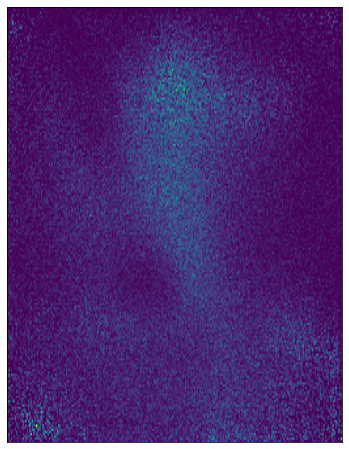

In [78]:
hist_accepted_samples, x_edges, y_edges = np.histogram2d(accepted[:,1].numpy(), accepted[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_accepted_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

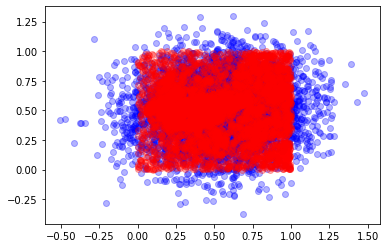

In [74]:
plt.scatter(q_samples[:5000,0], q_samples[:5000,1], color ='blue', alpha =0.3)
plt.scatter(target_samples[:5000,0], target_samples[:5000,1], color = 'red', alpha=0.3)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


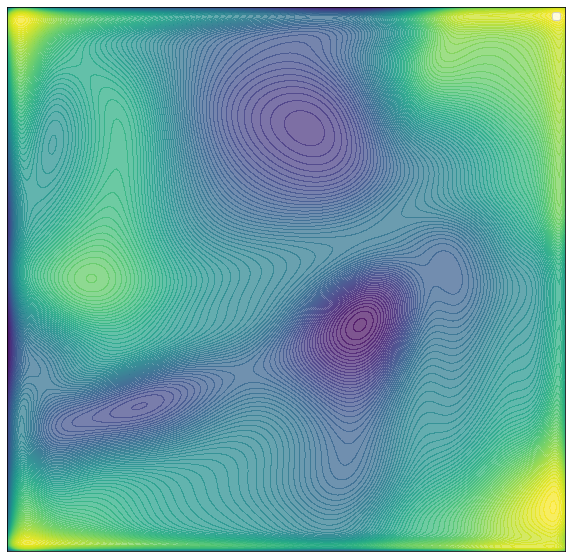

In [79]:
import matplotlib
def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, delta = 200, levels = 2 , alpha = 0.7, new_figure = True):
    if new_figure :
        plt.figure(figsize = (10,10))
        plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    tt_x = torch.linspace(x_min, x_max, delta)
    tt_y = torch.linspace(y_min,y_max, delta)
    mesh = torch.cartesian_prod(tt_x, tt_y)
    with torch.no_grad():
        plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, levels = levels, cmap = matplotlib.cm.get_cmap('viridis'), alpha = alpha)
        plt.legend()
    
plot_2d_function(lambda samples :torch.sigmoid(classif.logit_r(samples)), x_min = 0, x_max = 1 , y_min =0, y_max = 1, levels = 100)